<h1 style="text-decoration:underline;text-decoration:bold;text-align:center;"> 
    <b> Experimental Elastic Scattering Cross-Section Calculations (Classical) </b> 
</h1>

<h2 style="text-align:center;"> 
    39K(3He,3He)40Ca
</h2>

## Note: This notebook is obsolete. The new version is included in the transfer analysis: Transfer-Analysis/TransferCrossSections.ipynb

## This notebook does the following:
#### 1. Imports experimental elastic scattering run data and yield data from EngeSpec fits
#### 2. Calculates experimental elastic scattering cross-sections given nuclear physics and yield inputs
#### 3. Imports Fresco elastic scattering input file using a 3He global optical model potential (OMP)
#### 4. Compares the experimental data with the 3He global OMP

***

## Prerequisites:
#### 1.  Acquire fit parameters in text file for the P1 (Front Position) spectrum at each angle
#### 2.  Acquire fit parameters in text file for the Si detector spectrum at each angle
#### 3.  Tabulate run data in a spreadsheet to upload
#### 4.  Acquire Fresco elastic scattering input file with 3He global OMP

***

<h2 style="text-decoration:underline;"> 
    Imported Libraries
</h2>

In [1]:
import numpy as np
import pylab as py
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import re

<h1 style="text-decoration:underline;text-align:center;text-decoration:bold;"> 
    Inputs
</h1>

<h2 style="text-decoration:underline;"> 
    Inputs for EngeSpec Data
</h2>

In [2]:
f_EngeSpec_P1_fit_data = '../../Data/Yields_ES.dat' #Front Position (P1)
f_EngeSpec_Si_fit_data = '../../Data/Yields_Si_ES.dat' # Si Detector

num_params = 4 # number of fit parameters recorded (centroid, centroid uncertainty, peak area, etc..)
num_peaks_P1 = 1 # number of peaks in the P1 spectrum in which fit data was recorded (just 39K peak for now)

<h2 style="text-decoration:underline;"> 
    Inputs for Nuclear Physics
</h2>

In [3]:
f_run_data = '../../Data/ES-Spreadsheet.ods' # Spreadsheet with run data
ES_reaction = '39K(3He, 3He)40Ca'
# If removing 15 deg, include line to skip importing 15 deg run data
Theta_lab = [15, 20, 25, 30, 35, 40, 45, 50, 55, 59] # lab angles (15 deg 39K peak overlaps I peak in P1 spectrum. Assuming it forms a triple Gaussian, and the left-most peak is 39K)
#Theta_lab = [20, 25, 30, 35, 40, 45, 50, 55, 59] # lab angles (15 deg 39K peak overlaps I peak in P1 spectrum. Don't include until all fits are done with BayeSpec)

# Lab angles (in degrees) of the most stable portion of the target degradation (TD) plot. TD = Si peak area / BCI
# Taking an average of the Si peak area / BCI over these angles and correcting the cross-sections by this ratio
Si_Detector_Normalization_Angles = [35, 40, 45, 50]
Theta_Si_lab = 45 # Si detector lab angle in degrees
omega_Si = 4.23 # Si detector solid angle in msr

E_lab = 21 # projectile (beam) lab energy in MeV
u_E_lab = E_lab * 50 / (10**6) # uncertainty in projectile (beam) lab energy in MeV - 50 ppm of beam energy
x_prime = 0.0751 # Thickness per area of target [mg/cm^2]
BCI_scale = 10**(-10) # in Coulombs/pulse - from target current readout module in control room
zp = 2 # Unit charge of projectile
zt = 19 # Unit charge of target (isotope of interest in target molecule)
nu = 1 # Number of atoms of interest in target molecule (stoicheometry) - e.g. K in KI --> 1, Al in Al2O3 --> 2
At_molecule = 166.00277 # Atomic mass of target molecule [g/mole or u] - from www.webqc.org/molecular-weight-of-KI.html
u_At_molecule = 0.00013 # [g/mole or u]

# Atomic masses from 2020 AME Evaluation - Meng Wang et al 2021 Chinese Phys. C 45 030003
Ap_atomic =  3016029.32197 * 10**(-6) # Atomic mass of projectile [g/mole or u]
u_Ap_atomic = 0.00006 * 10**(-6) # Uncertainty of atomic mass of projectile [g/mole or u]
At_atomic =  38963706.487 * 10**(-6) # Atomic mass of isotope of interest in target [g/mole or u]
u_At_atomic = 0.005 * 10**(-6) # Uncertainty of atomic mass of isotope of interest in target [g/mole or u]

# Electron mass and unified atomic mass unit 'u' conversion to eV from 2020 AME Evaluation - W.J. Huang et al 2021 Chinese Phys. C 45 030002
Aelectron = 548579.909065 * 10**(-9) # [g/mole or u]
u_Aelectron = 0.000016 * 10**(-9) # [g/mole or u]
uam_eV = 931494.10242 * 10**(3) # [1 u = uam_eV eV]
u_uam_eV = 0.00028 * 10**(3)

# Meng Wang et al 2021 Chinese Phys. C 45 030003
# M_N = M_A - (Z * Aelectron) + B_e
def atomic_to_nuclear_mass_conversion(atomic_mass, Z):
    return atomic_mass - (Z * Aelectron) + (((14.4381 * Z**(2.39)) + (1.55468 * 10**(-6) * Z**(5.35))) / uam_eV)

# Nuclear Masses
Ap = atomic_to_nuclear_mass_conversion(Ap_atomic, zp)
At = atomic_to_nuclear_mass_conversion(At_atomic, zt)

print('Uncertainty in beam lab energy = ' + str(u_E_lab) + ' MeV')
print('Number of Angles = ' + str(len(Theta_lab)))

print('Projectile Nuclear Mass = ' + str(Ap) + ' u')
print('Target Nuclear Mass = ' + str(At) + ' u')

Uncertainty in beam lab energy = 0.00105 MeV
Number of Angles = 10
Projectile Nuclear Mass = 3.0149322433959993 u
Target Nuclear Mass = 38.953301122441 u


<h2 style="text-decoration:underline;"> 
    Inputs for Fresco
</h2>

In [4]:
# Root path containing all fresco files related to this experiment
# e.g. full path to an ES (fort.201) file would be fresco_root/fort.201
# all possible lnj combinations for each excited state are stored in this kind of file tree
fresco_root = '../../Data/Input_ES/'

# Extracted data from Vernotte paper
literature_root = '../../Data/Vernotte/'
#literature_root = '/home/wcfox/Software/fresco-3.4/3He-ES/Papers/Vernotte/'
literature_exp_data = 'Vernotte_Data.xls'

<h1 style="text-decoration:underline;text-align:center;text-decoration:bold;"> 
    Initial Calculations and Importing Data
</h1>

<h2 style="text-decoration:underline;"> 
    Importing EngeSpec Fit Data
</h2>

In [5]:
def import_data(text_file):
    file = open(text_file, 'r')
    lines = file.read().splitlines()
    data = []
    for line in lines:
        if not (line == ''):
            if not (line[0] == '#'):
                data.append(float(line.strip()))
    file.close()
    return data

# EngeSpec Front Position (P1) peak fit data
data_P1 = import_data(f_EngeSpec_P1_fit_data)

# EngeSpec Si Spectrum peak fit data
data_Si  = import_data(f_EngeSpec_Si_fit_data)

<h2 style="text-decoration:underline;"> 
    Importing Run Data
</h2>

In [6]:
# Load spreadsheet with run data
if (re.search('.ods', f_run_data) == None):
    tab = pd.read_excel(f_run_data, engine = 'openpyxl') #.xlsx files
else:
    tab = pd.read_excel(f_run_data, engine = 'odf') #.ods files

In [7]:
# Extract run data
BCI = []
omega = []
eff = []
clock = []
clocklive = []
run_num = []
for i in tab.index:
    #if (i > 0): # Skip 15 degree data
    BCI.append(tab['BCI'][i])
    omega.append(tab['Omega (msr)'][i])
    eff.append(tab['Efficiency'][i])
    clock.append(tab['Clock'][i])
    clocklive.append(tab['Clock Live'][i])
    run_num.append(tab['Run Number'][i])

<h2 style="text-decoration:underline;"> 
    Calculating Run Quantities
</h2>

In [8]:
q = []
for i in BCI:
    q.append(i * BCI_scale * 1000)
    
deadtime = []
livetime = []
for i in range(len(clock)):
    deadtime.append(1 - (clocklive[i]/clock[i]))
    livetime.append(clocklive[i]/clock[i])
    
run_num_increment = []
for i in range(len(run_num)):
    run_num_increment.append(i+1)
print('Incrementing run numbers:')
print(run_num_increment)

Incrementing run numbers:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


<h2 style="text-decoration:underline;"> 
    Conversion from Lab to Center-of-Mass Coordinates
</h2>

### Energy and Angle Conversions:

\begin{equation}
E_{CM} = E_{Lab} \frac{A_{t}}{A_{t} + A_{p}},
\end{equation}

\begin{equation}
\cos{\theta_{Lab}} = \frac{\gamma + \cos{\theta_{CM}}}{\sqrt{1 + \gamma^{2} + 2 \gamma \cos{\theta_{CM}}}},
\end{equation}

\begin{equation}
\gamma = \frac{A_{p}}{A_{t}}
\end{equation}

\begin{equation}
\frac{d \sigma}{d \Omega}_{CM} = \frac{d \sigma}{d \Omega}_{Lab} \frac{1 + \gamma \cos{\theta_{CM}}}{(1 + \gamma^{2} + 2 \gamma \cos{\theta_{CM}})^{3/2}}
\end{equation}

In [23]:
E_cm = E_lab * At / (At + Ap) # Total initial kinetic energy in the CM system. Projectile kinetic energy plus target kinetic energy in the CM system. This is more likely the right energy, according to Richard
#E_cm = E_lab * At**2 / (At + Ap)**2 # Kinetic energy of the projectile in the CM system. This agrees better with Liang's global 3He optical model potential
g = Ap / At # The general expression reduces to this for elastic scattering
Theta_cm = []
# Using positive solution of quadratic Eq. from Nuclear Physics of Stars pg. 585 Eq. C.38 (also shown above)
for i in Theta_lab:
    Theta_cm.append(np.arccos((g * (np.cos(i * np.pi / 180)**2 - 1)) + (np.cos(i * np.pi / 180) * np.sqrt(1 + (g**2 * (np.cos(i * np.pi / 180)**2 - 1))))) * 180 / np.pi)

Theta_Si_cm = np.arccos((g * (np.cos(Theta_Si_lab * np.pi / 180)**2 - 1)) + (np.cos(Theta_Si_lab * np.pi / 180) * np.sqrt(1 + (g**2 * (np.cos(Theta_Si_lab * np.pi / 180)**2 - 1))))) * 180 / np.pi
    
# Factor for converting lab cross-section to CM system - C.43, C.44 pg 586 Nuclear Physics of Stars
cross_conversion_factors = []
for i in Theta_cm:
    cross_conversion_factors.append((1 + (g * np.cos(i * np.pi / 180))) / (1 + g**2 + (2 * g * np.cos(i * np.pi / 180)))**(3/2))
    
cross_conversion_factor_Si = (1 + (g * np.cos(Theta_Si_cm * np.pi / 180))) / (1 + g**2 + (2 * g * np.cos(Theta_Si_cm * np.pi / 180)))**(3/2)
    
print('Lab Energy: ' + str(E_lab) + ' MeV')
print('CM Energy: ' + '{:.7f}'.format(E_cm) + ' MeV')
print('Gamma factor = ' + '{:.7f}'.format(g))
print('Lab Angles: ' + str(Theta_lab))
print('CM Angles: ' + str([float('{:.7f}'.format(x)) for x in Theta_cm]))
print('Si Lab Angle = ' + str(Theta_Si_lab))
print('Si CM Angle = ' + str(Theta_Si_cm))
print('Si CM Cross-Section Conversion Factor = ' + str(cross_conversion_factor_Si))

Lab Energy: 21 MeV
CM Energy: 19.4913928 MeV
Gamma factor = 0.0773986
Lab Angles: [15, 20, 25, 30, 35, 40, 45, 50, 55, 59]
CM Angles: [16.1478396, 21.5169049, 26.8744836, 32.2178613, 37.5444269, 42.8516928, 48.1373138, 53.3991057, 58.635062, 62.804001]
Si Lab Angle = 45
Si CM Angle = 48.13731384838989
Si CM Cross-Section Conversion Factor = 0.9001230600805581


<h1 style="text-decoration:underline;text-align:center;text-decoration:bold;"> 
    Class 1/2: P1 Spectrum Methods
</h1>

In [10]:
# Front Position (P1) spectrum peaks
# Each peak_P1 class object contains peak fit data and cross section calculations for a given peak in the P1 spectrum at each angle
# In spectrum, peak_num is 0, 1, 2, etc. from RIGHT to LEFT.
class peak_P1:

    # objects is a list of all the class objects. Used for class methods - functions that act on all class objects
    objects = []

    def __init__(self, peak_num):

        self.__class__.objects.append(self)
        self.peak_num = peak_num

        # Fit parameter data for all runs
        self.cent = []
        self.ucent = []
        #self.sd = []
        #self.usd = []
        self.netarea = []
        self.unetarea = []

        # Cross section quantities
        self.abs_exp_cross = []
        self.exp_cross_relativeToSi = []
        self.ruth_cross = []
        self.exp_cross_relativeToRuth = []
        self.exp_cross_relativeToSiandRuth = []
        
        # Cross section uncertainties
        self.u_abs_exp_cross = []
        self.u_exp_cross_relativeToSi = []
        self.u_ruth_cross = []
        self.u_exp_cross_relativeToRuth = []
        self.u_exp_cross_relativeToSiandRuth = []        
        
    def extract(self):
        for i in range(0, num_params):
            for j in range(i + (self.peak_num * num_params), len(data_P1), num_params * num_peaks_P1):
                if i == 0:
                    self.cent.append(data_P1[j])
                elif i == 1:
                    self.ucent.append(data_P1[j])
                #elif i == 2:
                #    self.sd.append(data_P1[j])
                #elif i == 3:
                #    self.usd.append(data_P1[j])
                elif i == 2:
                    self.netarea.append(data_P1[j])
                elif i == 3:
                    self.unetarea.append(data_P1[j])

    def calc_abs_exp_cross(self):
    # Calculate experimental differential cross sections at each angle without taking ratio to Si detector differential cross section
        for i in range(len(BCI)):
            cross_lab = self.netarea[i] * zp * At_molecule / (livetime[i] * omega[i] * q[i] * nu * x_prime * 3750 * 1000) # mb/sr in lab system
            cross_cm = cross_lab * cross_conversion_factors[i] # mb/sr in cm system
            self.abs_exp_cross.append(cross_cm)
            self.u_abs_exp_cross.append(cross_conversion_factors[i] * self.unetarea[i] * zp * At_molecule / (livetime[i] * omega[i] * q[i] * nu * x_prime * 3750 * 1000)) # in mb/sr
            
    def calc_exp_cross_relativeToSi(self, Si_cross, u_Si_cross):
    # Calculate experimental differential cross sections at each angle relative to Si detector differential cross section    
        for i in range(len(BCI)):
            self.exp_cross_relativeToSi.append(self.abs_exp_cross[i] / Si_cross[i])
            self.u_exp_cross_relativeToSi.append(self.exp_cross_relativeToSi[i] * np.sqrt((self.u_abs_exp_cross[i] / self.abs_exp_cross[i])**2 + (u_Si_cross[i] / Si_cross[i])**2))
        
    def calc_ruth_cross(self):
    #Calculate theoretical Rutherford differential cross sections at each angle
        for i in range(len(BCI)):
            self.ruth_cross.append(1.296 * (zp * zt / E_cm)**2 / (np.sin(Theta_cm[i] * np.pi / (2 * 180)))**4) # in mb/sr
            self.u_ruth_cross.append(u_E_lab * 2 * 1.296 * (zp * zt)**2 * At / ((E_cm**3) * (Ap + At) * (np.sin(Theta_cm[i] * np.pi / (2 * 180)))**4)) # in mb/sr        
    
    def calc_exp_cross_relativeToRuth(self):
    # Calculate experimental differential cross sections at each angle relative to the Rutherford differential cross section    
        for i in range(len(BCI)):
            self.exp_cross_relativeToRuth.append(self.abs_exp_cross[i] / self.ruth_cross[i])
            self.u_exp_cross_relativeToRuth.append(self.exp_cross_relativeToRuth[i] * np.sqrt((self.u_abs_exp_cross[i] / self.abs_exp_cross[i])**2 + (self.u_ruth_cross[i] / self.ruth_cross[i])**2))
            
    def calc_exp_cross_relativeToSiandRuth(self):
    # Calculate experimental differential cross sections at each angle relative to Si detector differential cross section and the Rutherford differential cross section
        for i in range(len(BCI)):
            self.exp_cross_relativeToSiandRuth.append(self.exp_cross_relativeToSi[i] / self.ruth_cross[i])
            self.u_exp_cross_relativeToSiandRuth.append(self.exp_cross_relativeToSiandRuth[i] * np.sqrt((self.u_exp_cross_relativeToSi[i] / self.exp_cross_relativeToSi[i])**2 + (self.u_ruth_cross[i] / self.ruth_cross[i])**2))

<h1 style="text-decoration:underline;text-align:center;text-decoration:bold;"> 
    Class 2/2: Si Spectrum Methods
</h1>

In [11]:
# Normalizing cross-sections by the average Si spectrum counts / BCI of the most stable portion of the counts/BCI plot. Corrects issues with target non-uniformity between retunes.

# Si spectrum peaks containing info about target degradation (or non-uniformities seen after retunes)
# Each peak_Si class object contains peak fit data and target degradation calculations for all runs
class peak_Si:
    
    objects = []
    
    def __init__(self):
        
        self.__class__.objects.append(self)
        
        # Param data for all runs
        self.cent = []
        self.ucent = []
        #self.sd = []
        #self.usd = []
        self.netarea = []
        self.unetarea = []
        
        self.TD = []
        self.TD_stable_avg = []
        self.TD_ratio = []
        self.abs_exp_cross = []
        
        self.u_TD = []
        self.u_TD_stable_avg = []
        self.u_TD_ratio = []
        self.u_abs_exp_cross = []
        
    def extract(self):
        for i in range(0, num_params):
            for j in range(i, len(data_Si), num_params):
                if i == 0:
                    self.cent.append(data_Si[j])
                elif i == 1:
                    self.ucent.append(data_Si[j])
                #elif i == 2:
                #    self.sd.append(data_Si[j])
                #elif i == 3:
                #    self.usd.append(data_Si[j])
                elif i == 2:
                    self.netarea.append(data_Si[j])
                elif i == 3:
                    self.unetarea.append(data_Si[j])
                    
    # Calculate the target degradation using the Si spectra peaks. TD = Si spectrum peak area / (BCI * livetime)
    def calc_TD(self):
        for i in range(len(BCI)):
            self.TD.append(self.netarea[i]/(BCI[i] * livetime[i]))
            self.u_TD.append(self.unetarea[i]/(BCI[i] * livetime[i]))
    
    # Calculate the average target degradation of the stable region from Si_Detector_Normalization_Angles
    def calc_TD_stable_avg(self):
        self.TD_stable_avg = np.mean(self.TD[Theta_lab.index(Si_Detector_Normalization_Angles[0]):Theta_lab.index(Si_Detector_Normalization_Angles[-1]) + 1])
        
        u_stable_TDs = self.u_TD[Theta_lab.index(Si_Detector_Normalization_Angles[0]):Theta_lab.index(Si_Detector_Normalization_Angles[-1]) + 1]
        
        u_stable_TDs_squared = []
        for i in u_stable_TDs:
            u_stable_TDs_squared.append(i ** 2)
            
        self.u_TD_stable_avg = (1 / len(Si_Detector_Normalization_Angles)) * np.sqrt(sum(u_stable_TDs_squared))
    
    # Calculate the ratios of the target degradations to the average target degradations of the stable region
    def calc_TD_ratio(self):
        for i in range(len(BCI)):
            self.TD_ratio.append(self.TD[i] / self.TD_stable_avg)
            self.u_TD_ratio.append(self.TD_ratio[i] * np.sqrt((self.u_TD[i] / self.TD[i])**2 + (self.u_TD_stable_avg / self.TD_stable_avg)**2))
            
    def calc_abs_exp_cross(self):
    # Calculate experimental Si differential cross sections at each P1 angle
        for i in range(len(BCI)):
            cross_lab = self.netarea[i] * zp * At_molecule / (livetime[i] * omega_Si * q[i] * nu * x_prime * 3750 * 1000) # mb/sr in lab system
            cross_cm = cross_lab * cross_conversion_factor_Si # mb/sr in cm system
            self.abs_exp_cross.append(cross_cm)
            self.u_abs_exp_cross.append(cross_conversion_factor_Si * self.unetarea[i] * zp * At_molecule / (livetime[i] * omega_Si * q[i] * nu * x_prime * 3750 * 1000)) # in mb/sr            

<h1 style="text-decoration:underline;text-align:center;text-decoration:bold;"> 
    Extract Fresco Data
</h1>

In [12]:
# Reading my Fresco OMPs
fresco_filepath = fresco_root + 'fort.201'
f_fresco = open(fresco_filepath, 'r')
lines = f_fresco.read().splitlines()
theta_fresco = []
sigma_fresco = []
for line in lines:
    if not (line[0] == '#' or line[0] == '@' or line == ' END'):
        x_vals = line[:14]
        y_vals = line[14:24]
        x_no_space = float(x_vals.strip())
        y_no_space = float(y_vals.strip())
        theta_fresco.append(x_no_space)
        sigma_fresco.append(y_no_space)
fresco_title = lines[1][9:].strip()
fresco_title = fresco_title.replace("\"", "")
f_fresco.close()

In [13]:
# Reading Vernotte's Data and Vernotte's OMPs (1982 Paper)

vernotte_exp_filepath = literature_root + literature_exp_data
tab = pd.read_excel(vernotte_exp_filepath)
theta_vernotte_exp = []
sigma_vernotte_exp = []
for i in tab.index:
    theta_vernotte_exp.append(tab['Theta_CM'][i])
    sigma_vernotte_exp.append(tab['Sigma'][i])
    
vernotte_fresco_filepath = literature_root + 'fort.201'
f_fresco = open(vernotte_fresco_filepath, 'r')
lines = f_fresco.read().splitlines()
theta_vernotte_fresco = []
sigma_vernotte_fresco = []
for line in lines:
    if not (line[0] == '#' or line[0] == '@' or line == ' END'):
        x_vals = line[:14]
        y_vals = line[14:24]
        x_no_space = float(x_vals.strip())
        y_no_space = float(y_vals.strip())
        theta_vernotte_fresco.append(x_no_space)
        sigma_vernotte_fresco.append(y_no_space)
vernotte_fresco_title = lines[1][9:].strip()
vernotte_fresco_title = vernotte_fresco_title.replace("\"", "")
f_fresco.close()

<h1 style="text-decoration:underline;text-align:center;text-decoration:bold;"> 
    Experiment Analysis
</h1>

In [14]:
### Create P1 object(s)
K39_P1 = peak_P1(0)
#I_P1 = peak_P1(0) # Could not retrieve all I, O, and C peaks. Don't need them for now anyway
#O_P1 = peak_P1(2)
#C_P1 = peak_P1(3)

### Create Si Object
Si = peak_Si()

### Extract fit data
K39_P1.extract()
Si.extract()

# Calculate the TD = target degradation (i.e. target non-uniformity) for each angle
Si.calc_TD()

# Calculate the avg TD for the most stable target and the ratios of all TD's to this avg
Si.calc_TD_stable_avg()
Si.calc_TD_ratio()

### Calculate Absolute Experimental Cross-Sections
K39_P1.calc_abs_exp_cross()
Si.calc_abs_exp_cross()

### Calculate the Focal Plane cross section relative to Si cross section
K39_P1.calc_exp_cross_relativeToSi(Si.abs_exp_cross, Si.u_abs_exp_cross)

### Calculate Rutherford Cross-Sections
K39_P1.calc_ruth_cross()

## Calculate the Focal Plane cross section relative to Rutherford cross section
K39_P1.calc_exp_cross_relativeToRuth()

### Calculate the ratio of the focal plane exp cross section to both the Si cross section and rutherford cross section
K39_P1.calc_exp_cross_relativeToSiandRuth()

<h1 style="text-decoration:underline;text-align:center;text-decoration:bold;"> 
    Plotting
</h1>

<h2 style="text-decoration:underline;"> 
    Target Degradation
</h2>

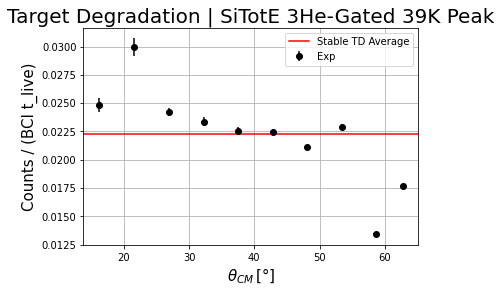

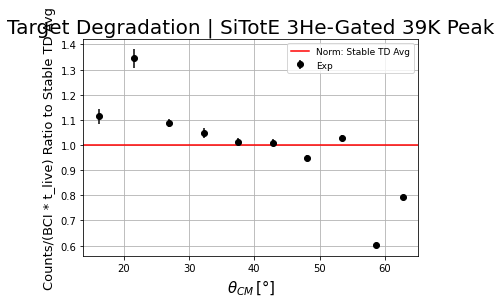

Stable TD Average = 0.022269590915090932


In [22]:
deg = u'\N{DEGREE SIGN}'

# Target Degradation
ax = py.subplot(111)
plt.errorbar(Theta_cm, Si.TD, yerr = Si.u_TD, c = 'k', ls = '', marker = 'o', label = 'Exp')
plt.axhline(y = Si.TD_stable_avg, c = 'r', ls = '-', label = 'Stable TD Average')
plt.legend(loc="best")
ax.set_xlabel(r'$\theta_{CM} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'Counts / (BCI t_live)', size = 15)
ax.set_title('Target Degradation | SiTotE 3He-Gated 39K Peak', size = 20)
plt.grid(True, which = 'both')
plt.show()

# Target Degradation Ratio
ax = py.subplot(111)
plt.errorbar(Theta_cm, Si.TD_ratio, yerr = Si.u_TD_ratio, c = 'k', ls = '', marker = 'o', label = 'Exp')
plt.axhline(y = 1, c = 'r', ls = '-', label = 'Norm: Stable TD Avg')
plt.legend(loc="best", fontsize = 9)
ax.set_xlabel(r'$\theta_{CM} \, [$' + deg + ']', size = 15)
ax.set_ylabel('Counts/(BCI * t_live) Ratio to Stable TD Avg', size = 13)
ax.set_title('Target Degradation | SiTotE 3He-Gated 39K Peak', size = 20)
plt.grid(True, which = 'both')
plt.show()

print('Stable TD Average = ' + str(Si.TD_stable_avg))

<h2 style="text-decoration:underline;"> 
    Experimental Differential Cross-Sections
</h2>

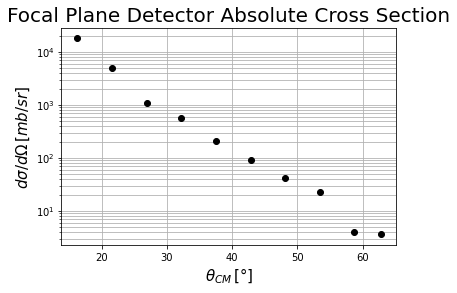

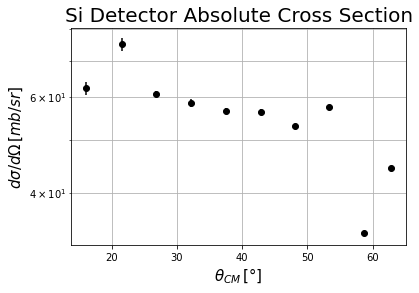

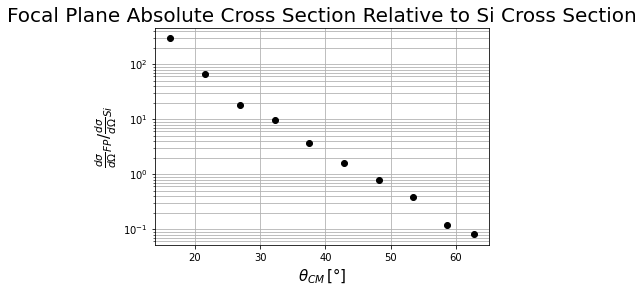

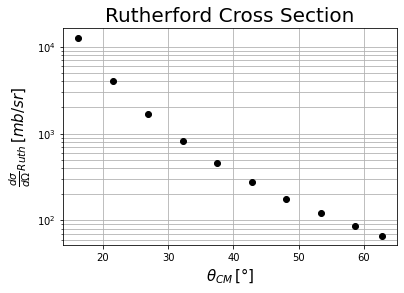

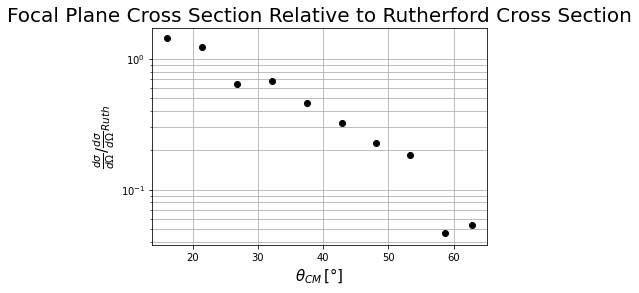

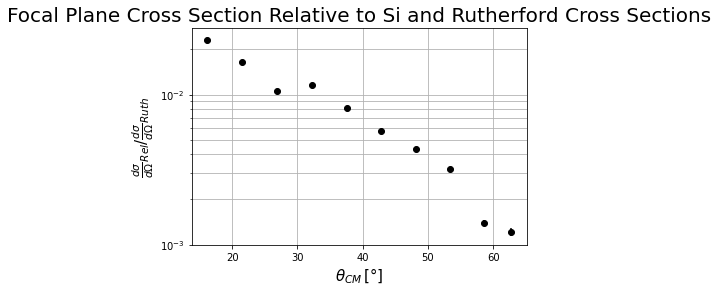

In [16]:
# Focal Plane Absolute Cross Section
ax = py.subplot(111)
plt.errorbar(Theta_cm, K39_P1.abs_exp_cross, yerr = K39_P1.u_abs_exp_cross, c = 'k', ls = '', marker = 'o')
ax.set_xlabel(r'$\theta_{CM} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$d \sigma / d \Omega \, [mb/sr]$', size = 15)
ax.set_title('Focal Plane Detector Absolute Cross Section', size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

# Si Detector Absolute Cross Section
ax = py.subplot(111)
plt.errorbar(Theta_cm, Si.abs_exp_cross, yerr = Si.u_abs_exp_cross, c = 'k', ls = '', marker = 'o')
ax.set_xlabel(r'$\theta_{CM} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$d \sigma / d \Omega \, [mb/sr]$', size = 15)
ax.set_title('Si Detector Absolute Cross Section', size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

# Focal Plane Cross Section Relative to Si Cross Section
ax = py.subplot(111)
plt.errorbar(Theta_cm, K39_P1.exp_cross_relativeToSi, yerr = K39_P1.u_exp_cross_relativeToSi, c = 'k', ls = '', marker = 'o')
ax.set_xlabel(r'$\theta_{CM} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'${\frac{d \sigma}{d \Omega}}_{FP} / {\frac{d \sigma}{d \Omega}}_{Si}$', size = 15)
ax.set_title('Focal Plane Absolute Cross Section Relative to Si Cross Section', size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

# Rutherford Cross Section
ax = py.subplot(111)
plt.errorbar(Theta_cm, K39_P1.ruth_cross, yerr = K39_P1.u_ruth_cross, c = 'k', ls = '', marker = 'o')
ax.set_xlabel(r'$\theta_{CM} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'${\frac{d \sigma}{d \Omega}}_{Ruth} \, [mb/sr]$', size = 15)
ax.set_title('Rutherford Cross Section', size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

# Focal Plane Cross Section Relative to Rutherford Cross Section
ax = py.subplot(111)
plt.errorbar(Theta_cm, K39_P1.exp_cross_relativeToRuth, yerr = K39_P1.u_exp_cross_relativeToRuth, c = 'k', ls = '', marker = 'o')
ax.set_xlabel(r'$\theta_{CM} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$\frac{d \sigma}{d \Omega} / {\frac{d \sigma}{d \Omega}}_{Ruth}$', size = 15)
ax.set_title('Focal Plane Cross Section Relative to Rutherford Cross Section', size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

# Focal Plane Cross Section Relative to Si Cross Section and Rutherford Cross Section
ax = py.subplot(111)
plt.errorbar(Theta_cm, K39_P1.exp_cross_relativeToSiandRuth, yerr = K39_P1.u_exp_cross_relativeToSiandRuth, c = 'k', ls = '', marker = 'o')
ax.set_xlabel(r'$\theta_{CM} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'${\frac{d \sigma}{d \Omega}}_{Rel} / {\frac{d \sigma}{d \Omega}}_{Ruth}$', size = 15)
ax.set_title('Focal Plane Cross Section Relative to Si and Rutherford Cross Sections', size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

<h2 style="text-decoration:underline;"> 
    Fresco (3He global OMP) and Experiment Comparison
</h2>

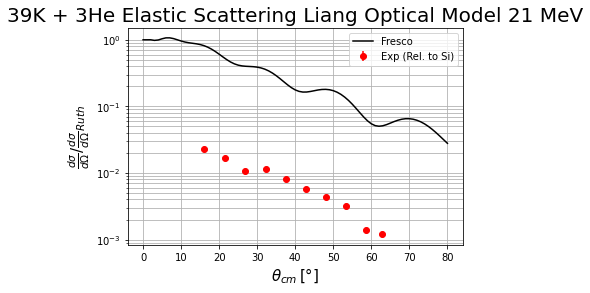

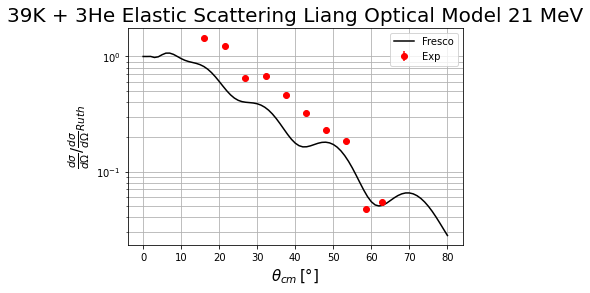

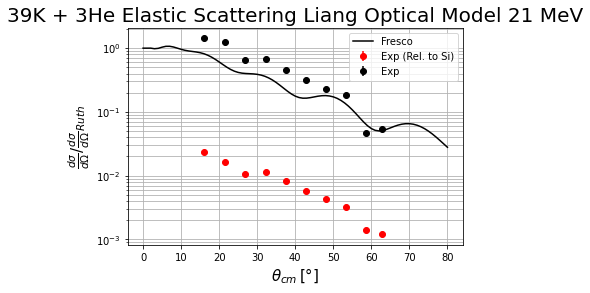

In [17]:
# Si Normalization
ax = py.subplot(111)
ax.plot(theta_fresco, sigma_fresco, c = 'k', label = 'Fresco')
plt.errorbar(Theta_cm, K39_P1.exp_cross_relativeToSiandRuth, yerr = K39_P1.u_exp_cross_relativeToSiandRuth, c = 'r', ls = '', marker = 'o', label = 'Exp (Rel. to Si)')
plt.legend(loc="best")
ax.set_xlabel(r'$\theta_{cm} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$\frac{d \sigma}{d \Omega} / {\frac{d \sigma}{d \Omega}}_{Ruth}$', size = 15)
ax.set_title(fresco_title, size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

# No Si Normalization
ax = py.subplot(111)
ax.plot(theta_fresco, sigma_fresco, c = 'k', label = 'Fresco')
plt.errorbar(Theta_cm, K39_P1.exp_cross_relativeToRuth, yerr = K39_P1.u_exp_cross_relativeToRuth, c = 'r', ls = '', marker = 'o', label = 'Exp')
plt.legend(loc="best")
ax.set_xlabel(r'$\theta_{cm} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$\frac{d \sigma}{d \Omega} / {\frac{d \sigma}{d \Omega}}_{Ruth}$', size = 15)
ax.set_title(fresco_title, size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

# Comparison between Si and No Si Normalization
ax = py.subplot(111)
ax.plot(theta_fresco, sigma_fresco, c = 'k', label = 'Fresco')
plt.errorbar(Theta_cm, K39_P1.exp_cross_relativeToSiandRuth, yerr = K39_P1.u_exp_cross_relativeToSiandRuth, c = 'r', ls = '', marker = 'o', label = 'Exp (Rel. to Si)')
plt.errorbar(Theta_cm, K39_P1.exp_cross_relativeToRuth, yerr = K39_P1.u_exp_cross_relativeToRuth, c = 'k', ls = '', marker = 'o', label = 'Exp')
plt.legend(loc="best")
ax.set_xlabel(r'$\theta_{cm} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$\frac{d \sigma}{d \Omega} / {\frac{d \sigma}{d \Omega}}_{Ruth}$', size = 15)
ax.set_title(fresco_title, size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

<h2 style="text-decoration:underline;"> 
    Scaling Data to Global Model to Recover Si Detector Normalization
</h2>

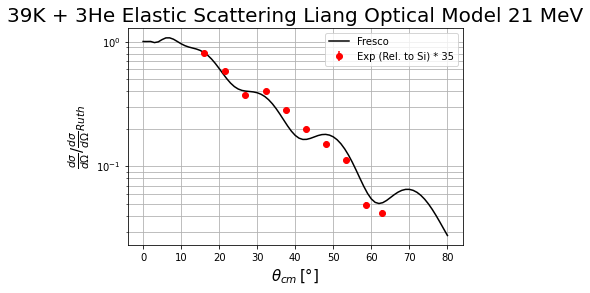

In [18]:
# Scaling Si Normalization to global model
norm = 35
exp_cross_relativeToSiandRuth_norm = [x * norm for x in K39_P1.exp_cross_relativeToSiandRuth]
u_exp_cross_relativeToSiandRuth_norm = [x * norm for x in K39_P1.u_exp_cross_relativeToSiandRuth]

ax = py.subplot(111)
ax.plot(theta_fresco, sigma_fresco, c = 'k', label = 'Fresco')
plt.errorbar(Theta_cm, exp_cross_relativeToSiandRuth_norm, yerr = u_exp_cross_relativeToSiandRuth_norm, c = 'r', ls = '', marker = 'o', label = 'Exp (Rel. to Si) * ' + str(norm))
plt.legend(loc="best")
ax.set_xlabel(r'$\theta_{cm} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$\frac{d \sigma}{d \Omega} / {\frac{d \sigma}{d \Omega}}_{Ruth}$', size = 15)
ax.set_title(fresco_title, size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

In [21]:
print('Exp Cross-Sections (Relative to Si and Ruth):')
print(K39_P1.exp_cross_relativeToSiandRuth)
print('\nExp Cross Section Uncertainties (Relative to Si and Ruth):')
print(K39_P1.u_exp_cross_relativeToSiandRuth)
print('\nExp Cross Sections (Relative to Si and Ruth) Scaled by ' + str(norm) + ' to Global Optical Model:')
print(exp_cross_relativeToSiandRuth_norm)
print('\nExp Cross SectionIt should also be noted that the experimental uncertainties for these points are
roughly 10%. Uncertainties (Relative to Si and Ruth) Scaled by ' + str(norm) + ' to Global Optical Model:')
print(u_exp_cross_relativeToSiandRuth_norm)
print('\nCM Angles:')
print(Theta_cm)

Exp Cross-Sections (Relative to Si and Ruth):
[0.023293689089081932, 0.016559865024728913, 0.010600641457004067, 0.011551277964041809, 0.008118849707035058, 0.005718439924279338, 0.004330425701974652, 0.0032119175581739982, 0.001396321426878749, 0.001215802671325767]

Exp Cross Section Uncertainties (Relative to Si and Ruth):
[0.0006087714319257, 0.000476700944619366, 0.00016896529362577927, 0.0002602872376875212, 0.00018195238167808994, 0.00012022668993939247, 9.933355774920779e-05, 0.00010095123575048444, 7.330342558857604e-05, 6.570311618177333e-05]

Exp Cross Sections (Relative to Si and Ruth) Scaled by 35 to Global Optical Model:
[0.8152791181178676, 0.579595275865512, 0.37102245099514236, 0.4042947287414633, 0.28415973974622705, 0.20014539734977682, 0.15156489956911282, 0.11241711453608993, 0.048871249940756215, 0.04255309349640185]

Exp Cross Section Uncertainties (Relative to Si and Ruth) Scaled by 35 to Global Optical Model:
[0.0213070001173995, 0.01668453306167781, 0.00591378